# Task 1: Introduction

---

For this project, we are going to work on evaluating price of houses given the following features:

1. Year of sale of the house
2. The age of the house at the time of sale
3. Distance from city center
4. Number of stores in the locality
5. The latitude
6. The longitude

![Regression](images/regression.png)

Note: This notebook uses `python 3` and these packages: `tensorflow`, `pandas`, `matplotlib`, `scikit-learn`.

## 1.1: Importing Libraries & Helper Functions

First of all, we will need to import some libraries and helper functions. This includes TensorFlow and some utility functions that I've written to save time.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from utils import *
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, LambdaCallback

%matplotlib inline
#tf.logging.set_verbosity(tf.logging.ERROR)

print('Libraries imported.')

Libraries imported.


# Task 2: Importing the Data

## 2.1: Importing the Data

The dataset is saved in a `data.csv` file. We will use `pandas` to take a look at some of the rows.

In [3]:
df = pd.read_csv('data.csv', names = column_names) 
df.head()

,serial,date,age,distance,stores,latitude,longitude,price
0,0,2009,21,9,6,84,121,14264
1,1,2007,4,2,3,86,121,12032
2,2,2016,18,3,7,90,120,13560
3,3,2002,13,2,2,80,128,12029
4,4,2014,25,5,8,81,122,14157


## 2.2: Check Missing Data

It's a good practice to check if the data has any missing values. In real world data, this is quite common and must be taken care of before any data pre-processing or model training.

In [4]:
df.isna().sum()

serial       0
date         0
age          0
distance     0
stores       0
latitude     0
longitude    0
price        0
dtype: int64

# Task 3: Data Normalization

## 3.1: Data Normalization

We can make it easier for optimization algorithms to find minimas by normalizing the data before training a model.

In [5]:
df = df.iloc[:,1:]
df_norm = (df - df.mean()) / df.std()
df_norm.head()

,date,age,distance,stores,latitude,longitude,price
0,0.015978,0.181384,1.257002,0.345224,-0.307212,-1.260799,0.350088
1,-0.350485,-1.319118,-0.930610,-0.609312,0.325301,-1.260799,-1.836486
2,1.298598,-0.083410,-0.618094,0.663402,1.590328,-1.576456,-0.339584
3,-1.266643,-0.524735,-0.930610,-0.927491,-1.572238,0.948803,-1.839425
4,0.932135,0.534444,0.006938,0.981581,-1.255981,-0.945141,0.245266


## 3.2: Convert Label Value

Because we are using normalized values for the labels, we will get the predictions back from a trained model in the same distribution. So, we need to convert the predicted values back to the original distribution if we want predicted prices.

In [6]:
y_mean = df['price'].mean()
y_std = df['price'].std()

def convert_label_value(pred):
    return int(pred * y_std + y_mean)

print(convert_label_value(0.350088))

14263


# Task 4: Create Training and Test Sets

## 4.1: Select Features

Make sure to remove the column __price__ from the list of features as it is the label and should not be used as a feature.

In [7]:
X = df_norm.iloc[:, :6]
X.head()

,date,age,distance,stores,latitude,longitude
0,0.015978,0.181384,1.257002,0.345224,-0.307212,-1.260799
1,-0.350485,-1.319118,-0.930610,-0.609312,0.325301,-1.260799
2,1.298598,-0.083410,-0.618094,0.663402,1.590328,-1.576456
3,-1.266643,-0.524735,-0.930610,-0.927491,-1.572238,0.948803
4,0.932135,0.534444,0.006938,0.981581,-1.255981,-0.945141


## 4.2: Select Labels

In [8]:
Y = df_norm.iloc[:, -1]
Y.head()

0    0.350088
1   -1.836486
2   -0.339584
3   -1.839425
4    0.245266
Name: price, dtype: float64

## 4.3: Feature and Label Values

We will need to extract just the numeric values for the features and labels as the TensorFlow model will expect just numeric values as input.

In [9]:
X_arr = X.values
Y_arr = Y.values

print('X_arr shape: ', X_arr.shape)
print('Y_arr shape: ', Y_arr.shape)

X_arr shape:  (5000, 6)
Y_arr shape:  (5000,)


## 4.4: Train and Test Split

We will keep some part of the data aside as a __test__ set. The model will not use this set during training and it will be used only for checking the performance of the model in trained and un-trained states. This way, we can make sure that we are going in the right direction with our model training.

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X_arr, Y_arr, test_size = 0.05, shuffle = True, random_state=0)

print('X_train shape: ', X_train.shape)
print('y_train shape: ', y_train.shape)
print('X_test shape: ', X_test.shape)
print('y_test shape: ', y_test.shape)

X_train shape:  (4750, 6)
y_train shape:  (4750,)
X_test shape:  (250, 6)
y_test shape:  (250,)


# Task 5: Create the Model

## 5.1: Create the Model

Let's write a function that returns an untrained model of a certain architecture.

In [11]:
def get_model():
    
    model = Sequential([
        Dense(10, input_shape = (6,), activation = 'relu'),
        Dense(20, activation = 'relu'),
        Dense(5, activation = 'relu'),
        Dense(1)
    ])

    model.compile(
        loss='mse',
        optimizer='adadelta'
    )
    
    return model

model = get_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                70        
_________________________________________________________________
dense_1 (Dense)              (None, 20)                220       
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 105       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 6         
Total params: 401
Trainable params: 401
Non-trainable params: 0
_________________________________________________________________


# Task 6: Model Training

## 6.1: Model Training

We can use an `EarlyStopping` callback from Keras to stop the model training if the validation loss stops decreasing for a few epochs.

In [12]:
early_stopping = EarlyStopping(monitor='val_loss', patience = 5)

model = get_model()

preds_on_untrained = model.predict(X_test)

history = model.fit(
    X_train, y_train,
    validation_data = (X_test, y_test),
    epochs = 1000,
    callbacks = [early_stopping]
)

Epoch 1/1000
149/149 [==============================] - 0s 3ms/step - loss: 0.9814 - val_loss: 0.8603
Epoch 2/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.9801 - val_loss: 0.8590
Epoch 3/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.9788 - val_loss: 0.8576
Epoch 4/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.9775 - val_loss: 0.8563
Epoch 5/1000
149/149 [==============================] - 0s 3ms/step - loss: 0.9762 - val_loss: 0.8550
Epoch 6/1000
149/149 [==============================] - 0s 3ms/step - loss: 0.9749 - val_loss: 0.8537
Epoch 7/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.9737 - val_loss: 0.8524
Epoch 8/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.9724 - val_loss: 0.8511
Epoch 9/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.9712 - val_loss: 0.8498
Epoch 10/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.970

Epoch 159/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.8308 - val_loss: 0.7000
Epoch 160/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.8301 - val_loss: 0.6991
Epoch 161/1000
149/149 [==============================] - 0s 3ms/step - loss: 0.8293 - val_loss: 0.6982
Epoch 162/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.8285 - val_loss: 0.6974
Epoch 163/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.8277 - val_loss: 0.6965
Epoch 164/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.8269 - val_loss: 0.6956
Epoch 165/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.8262 - val_loss: 0.6948
Epoch 166/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.8254 - val_loss: 0.6940
Epoch 167/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.8246 - val_loss: 0.6931
Epoch 168/1000
149/149 [==============================] - 0s 2ms

Epoch 238/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.7719 - val_loss: 0.6367
Epoch 239/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.7712 - val_loss: 0.6359
Epoch 240/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.7705 - val_loss: 0.6351
Epoch 241/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.7698 - val_loss: 0.6343
Epoch 242/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.7691 - val_loss: 0.6336
Epoch 243/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.7684 - val_loss: 0.6328
Epoch 244/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.7677 - val_loss: 0.6320
Epoch 245/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.7670 - val_loss: 0.6313
Epoch 246/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.7662 - val_loss: 0.6305
Epoch 247/1000
149/149 [==============================] - 0s 1ms

Epoch 395/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.6677 - val_loss: 0.5297
Epoch 396/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.6671 - val_loss: 0.5291
Epoch 397/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.6665 - val_loss: 0.5285
Epoch 398/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.6658 - val_loss: 0.5278
Epoch 399/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.6652 - val_loss: 0.5272
Epoch 400/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.6646 - val_loss: 0.5266
Epoch 401/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.6639 - val_loss: 0.5260
Epoch 402/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.6633 - val_loss: 0.5254
Epoch 403/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.6627 - val_loss: 0.5247
Epoch 404/1000
149/149 [==============================] - 0s 1ms

Epoch 474/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.6186 - val_loss: 0.4810
Epoch 475/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.6180 - val_loss: 0.4804
Epoch 476/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.6173 - val_loss: 0.4798
Epoch 477/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.6167 - val_loss: 0.4793
Epoch 478/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.6161 - val_loss: 0.4787
Epoch 479/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.6155 - val_loss: 0.4781
Epoch 480/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.6149 - val_loss: 0.4775
Epoch 481/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.6143 - val_loss: 0.4769
Epoch 482/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.6137 - val_loss: 0.4764
Epoch 483/1000
149/149 [==============================] - 0s 1ms

Epoch 553/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.5707 - val_loss: 0.4365
Epoch 554/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.5700 - val_loss: 0.4360
Epoch 555/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.5694 - val_loss: 0.4354
Epoch 556/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.5688 - val_loss: 0.4349
Epoch 557/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.5682 - val_loss: 0.4344
Epoch 558/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.5676 - val_loss: 0.4339
Epoch 559/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.5670 - val_loss: 0.4333
Epoch 560/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.5664 - val_loss: 0.4328
Epoch 561/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.5658 - val_loss: 0.4323
Epoch 562/1000
149/149 [==============================] - 0s 1ms

Epoch 710/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.4778 - val_loss: 0.3561
Epoch 711/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.4773 - val_loss: 0.3556
Epoch 712/1000
149/149 [==============================] - ETA: 0s - loss: 0.472 - 0s 1ms/step - loss: 0.4767 - val_loss: 0.3551
Epoch 713/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.4761 - val_loss: 0.3546
Epoch 714/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.4756 - val_loss: 0.3542
Epoch 715/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.4750 - val_loss: 0.3537
Epoch 716/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.4744 - val_loss: 0.3532
Epoch 717/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.4739 - val_loss: 0.3528
Epoch 718/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.4733 - val_loss: 0.3523
Epoch 719/1000
149/149 [================

149/149 [==============================] - 0s 1ms/step - loss: 0.3948 - val_loss: 0.2887
Epoch 867/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.3943 - val_loss: 0.2883
Epoch 868/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.3938 - val_loss: 0.2879
Epoch 869/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.3933 - val_loss: 0.2875
Epoch 870/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.3928 - val_loss: 0.2871
Epoch 871/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.3923 - val_loss: 0.2867
Epoch 872/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.3919 - val_loss: 0.2863
Epoch 873/1000
149/149 [==============================] - 0s 3ms/step - loss: 0.3914 - val_loss: 0.2859
Epoch 874/1000
149/149 [==============================] - 0s 3ms/step - loss: 0.3909 - val_loss: 0.2855
Epoch 875/1000
149/149 [==============================] - 0s 2ms/step - loss: 0

Epoch 945/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.3591 - val_loss: 0.2611
Epoch 946/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.3586 - val_loss: 0.2608
Epoch 947/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.3582 - val_loss: 0.2605
Epoch 948/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.3578 - val_loss: 0.2602
Epoch 949/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.3574 - val_loss: 0.2599
Epoch 950/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.3569 - val_loss: 0.2595
Epoch 951/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.3565 - val_loss: 0.2592
Epoch 952/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.3561 - val_loss: 0.2589
Epoch 953/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.3557 - val_loss: 0.2586
Epoch 954/1000
149/149 [==============================] - 0s 2ms

## 6.2: Plot Training and Validation Loss

Let's use the `plot_loss` helper function to take a look training and validation loss.

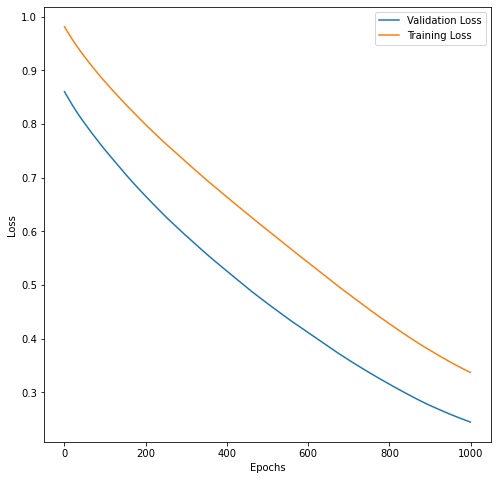

In [13]:
plot_loss(history)

# Task 7: Predictions

## 7.1: Plot Raw Predictions

Let's use the `compare_predictions` helper function to compare predictions from the model when it was untrained and when it was trained.

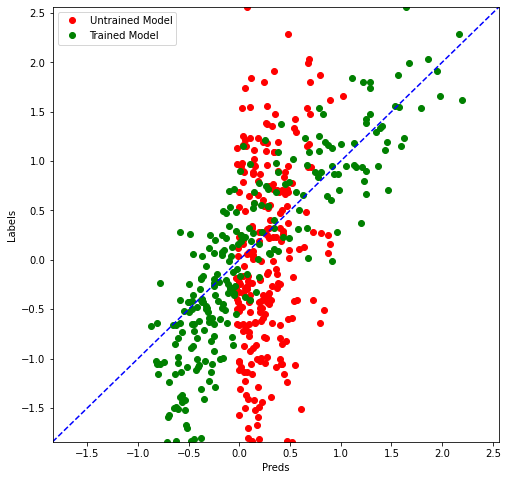

In [14]:
preds_on_trained = model.predict(X_test)

compare_predictions(preds_on_untrained, preds_on_trained, y_test)

## 7.2: Plot Price Predictions

The plot for price predictions and raw predictions will look the same with just one difference: The x and y axis scale is changed.

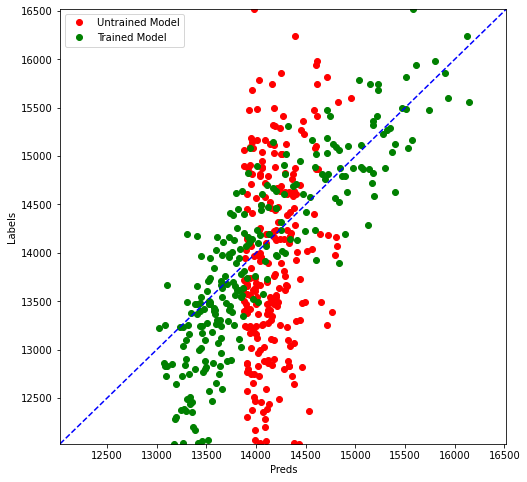

In [15]:
price_on_untrained = [convert_label_value(y) for y in preds_on_untrained]
price_on_trained = [convert_label_value(y) for y in preds_on_trained]
price_y_test = [convert_label_value(y) for y in y_test]

compare_predictions(price_on_untrained, price_on_trained, price_y_test)